# Week3: Using Grover's algorithm to solve the Max Cut problem
This week we will try solving a famous problem called the Maximum Cut Problem (or Max Cut in short) using Grover's algorithm we learned in week 2.

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

## The Max Cut Problem

The Maximum Cut problem, or Max Cut in short, is a problem involving separating the vertex set of an undirected graph into two zones in order to maximize the number of edges crossing the two zones. Here we denote any undirected graph as G, vertices as V and edges as E. The two groups when separated by a line (or a cut) will be separate zones.

Given this notation, we need to find out how to maximize the number of edges E that crosses between the two zones.

### Solving the Max Cut problem using a quantum algorithm
There are several approaches to solving a Max Cut problem using a quantum algorithm such as:  
[Quantum Approximate Optimization Algorithm (QAOA)](https://qiskit.org/documentation/aqua/optimization/qiskit_optimization.html) and 
[Variational Quantum Eigensolver (VQE)](https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747).

Here we are going to use Grover's algorithm we used in week2 to solve this problem.

Let us start with a simple example where we have
(0,1,2）as our three vertices and
(0,1),(1,2) as our two edges connecting these vertices.
<img src="maxcut.png" width="320">


Let us cut this graph to create two zones in three different ways. (The edges crossing different zones will be called **'cut-edges'** from here on.)
As you can see here, the first cut pattern gives us the maximum value of edges crossing different zones.
And there you have it. The maximum value of cut-edges for this graph is 2.

### Judging the cut-edges using a quantum circuit
Let us first build a judgement circuit to determine if we have a cut-edge or not in a graph.

When the vertices (a, b) are in the same zone, then the oracle will give us 0. 
When the vertices (a, b) are in a different group or zone, then the oracle will give us 1.  
We assign qubits to each vertex and then assign 0 and 1 to each subgraph (zone).   
Look at the truth table below. Notice that the results are the same as an XOR circuit you learned in week1.

|Vertex a|Vertex b|Result|
|--|--|--|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|0|

Let us look at what the corresponding circuit looks like.   
In order to accept all combinations as an input, we apply the Hadamard gate to all qubits that are assigned to the vertices.

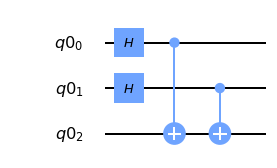

In [3]:
q = QuantumRegister(3)
qc = QuantumCircuit(q)

#cutedge checker
def ccheck(a, b, c): 
    qc.cx(q[a], q[c]) 
    qc.cx(q[b], q[c])

qc.h(q[0])
qc.h(q[1])
ccheck(0,1,2)
qc.draw(output='mpl')

## Counting the cut-edges
By combining this judgement circuit with the (half) adder we learned in week 1, we can count the cut-edges as a result of the input.

Let's look at the graph above again. It has 3 vertices and 2 edges. <br/>
For our subgraph containing its vertices in q[0],q[1],q[2], we encode the judgement results to q[3],q[4] and the number of cut-edges to q[5],q[6].

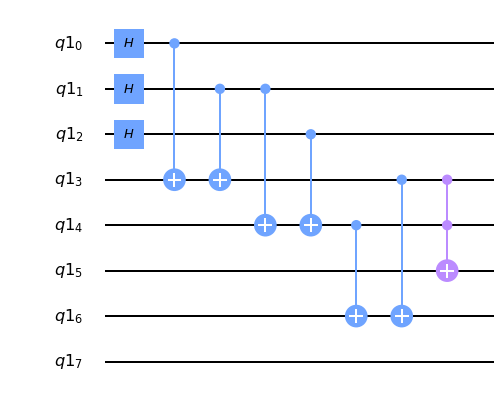

In [4]:
q = QuantumRegister(8)
qc = QuantumCircuit(q)

#half adder
#inputs: a,b 
#outputs: the sum output s and carry output c
def hadder(a,b,s,c):
    #XOR
    qc.cx(q[b], q[s])
    qc.cx(q[a], q[s])
    #AND
    qc.ccx(q[a], q[b], q[c])

qc.h(q[0:3])
ccheck(0,1,3)
ccheck(1,2,4)
hadder(3,4,6,5)

qc.draw(output='mpl')

Now we have a circuit that counts the cut-edges. 


## Creating an Oracle for the Max Cut Problem
Recall from the “Grover’s Search Algorithm” we learned in week 2 that the marking operation is completely determined by the Boolean oracle function f, which takes a single quantum state as an input and spits out whether or not the state is a search target. This means, we simply need to create a circuit that will either say 'Yes' or 'No' according to the input.

Let's say we want to create an oracle that can determine whether the cut-edges are 2 or more. We can do this by setting the threshold to 2 and judge whether the carry output (q[5]) is 1 or not.

{'0': 75157, '1': 24843}


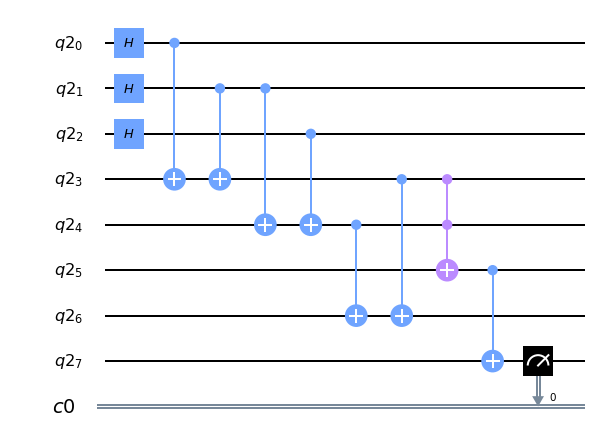

In [5]:
#create an oracle
q = QuantumRegister(8)
c = ClassicalRegister(1)
qc = QuantumCircuit(q,c)

qc.h(q[0:3])
ccheck(0,1,3)
ccheck(1,2,4)
hadder(3,4,6,5)
qc.cx(q[5],q[7])
qc.measure(q[7], c[0])

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=100000)
result = job.result()
count =result.get_counts()
print(count)
qc.draw(output='mpl')

From the results, we can see that out of the total counts, 25％ were measured as 1.
The only input states that would give a cut-edge count of two in this example are 010 and 101. That's two out of all eight possible states (25%!). Our oracle does seem reasonable.

By changing q[7] to |->、and applying cx(q[5],q[7]), we can flip the phase of 010 and 101.

After operating the phase flip, we reverse all operations we have applied so far to bring q[3] to q[6] back to their initial states. 
This operation is performed to eliminate unnecessary entanglements between the input qubits q[0] to q[2] and oracle qubits.

{'0000001': 122, '0000101': 111, '0000000': 113, '0000100': 139, '0000010': 121, '0000110': 130, '0000111': 128, '0000011': 136}


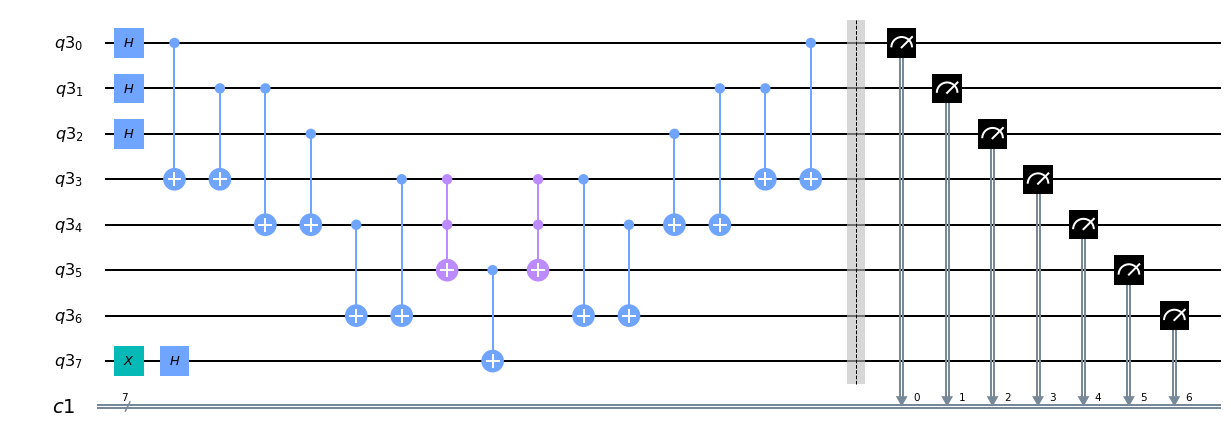

In [6]:
q = QuantumRegister(8)
c = ClassicalRegister(7)
qc = QuantumCircuit(q,c)

#inverse operations
def iccheck(a, b, c): 
    qc.cx(q[b], q[c])
    qc.cx(q[a], q[c]) 
def ihadder(a,b,s,c):
    qc.ccx(q[a], q[b], q[c])
    qc.cx(q[a], q[s])
    qc.cx(q[b], q[s])

qc.h(q[0:3])
qc.x(q[7])
qc.h(q[7])

ccheck(0,1,3)
ccheck(1,2,4)
hadder(3,4,6,5)
qc.cx(q[5],q[7])
ihadder(3,4,6,5)
iccheck(1,2,4)
iccheck(0,1,3)
qc.barrier()
qc.measure(q[0:7], c[0:7])

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()
count =result.get_counts()
print(count)
qc.draw(output='mpl')

Please note the result counts (i.e. probability distribution). You can see that all eight output states have similar probabilities of being measured and that q[3]~q[6] are initialized to 0. 
The q[7] which is not being measured is always in the |-> state. Thus, the phase flip is something you won't be able to see in the probability distribution. 

# Completing our circuit for the Max Cut Problem
By adding the Diffusion circuit (a.k.a. amplitude amplification) we learned in the previous week, we can complete our circuit for our Max Cut Problem.
Let's try and see if we can obtain the right answer  010 and 101 with high probability.

{'010': 5018, '101': 4982}


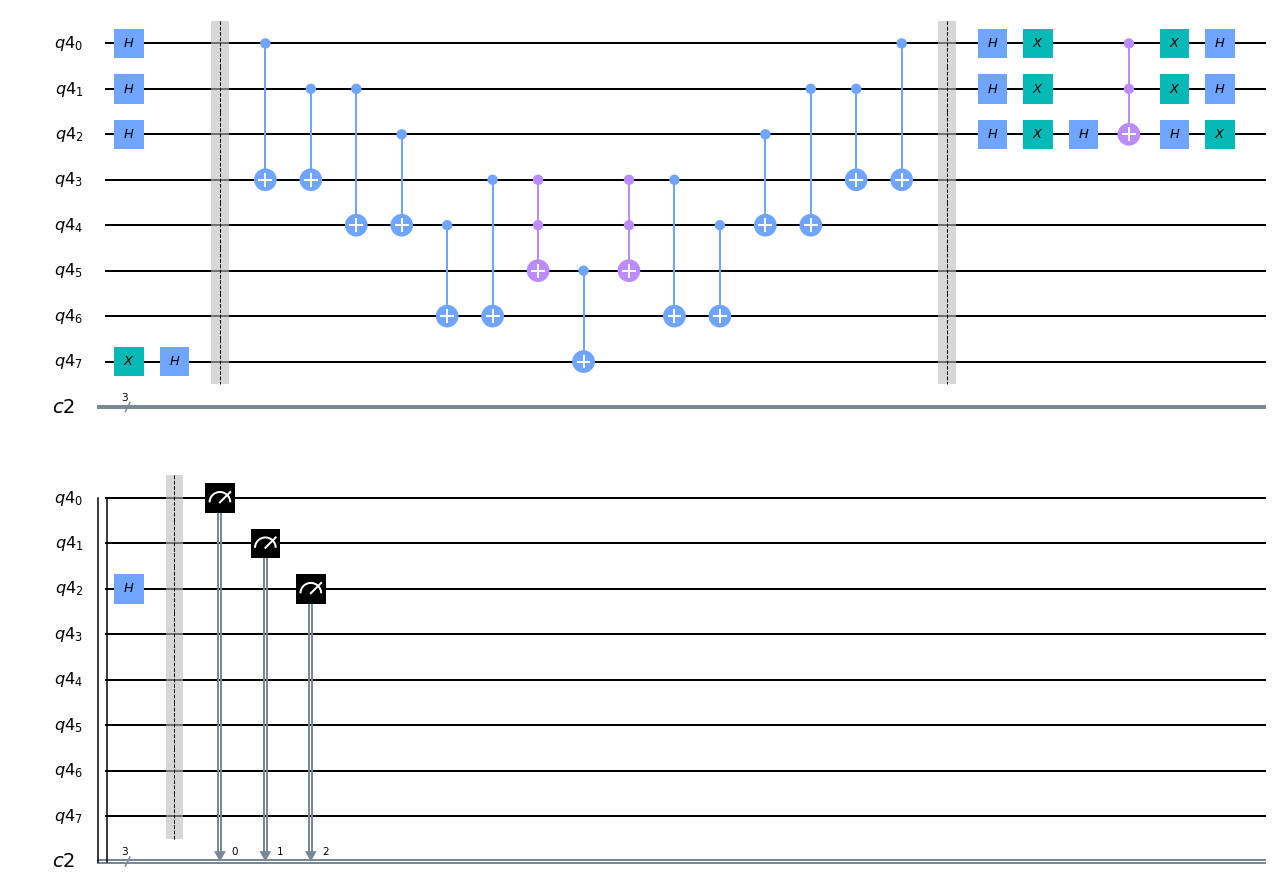

In [7]:
q = QuantumRegister(8)
c = ClassicalRegister(3)
qc = QuantumCircuit(q,c)

#diffusion operations
def diffusion(a,b,c):
    qc.h(q[a])
    qc.h(q[b])
    qc.h(q[c])    
    qc.x(q[a])
    qc.x(q[b])
    qc.x(q[c])
    qc.h(q[c])  
    qc.ccx(q[a],q[b], q[c])
    qc.h(q[c])  
    qc.x(q[a])
    qc.x(q[b])
    qc.x(q[c])
    qc.h(q[a])
    qc.h(q[b])
    qc.h(q[c])

#initialization
qc.h(q[0:3])
qc.x(q[7])
qc.h(q[7])
qc.barrier()

#oracle part
ccheck(0,1,3)
ccheck(1,2,4)
hadder(3,4,6,5)
qc.cx(q[5],q[7])
ihadder(3,4,6,5)
iccheck(1,2,4)
iccheck(0,1,3)
qc.barrier()

#diffusion part
diffusion(0,1,2)
qc.barrier()
qc.measure(q[0:3], c[0:3])

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=10000)
result = job.result()
count =result.get_counts()
print(count)
qc.draw(output='mpl')

We've successfully obtained our answers.

## A useful gate to share before we go into this week's Learning Challenge...

### Diffusion implementation for n-qubit controls
So far, we have been looking at problems that only require ~8 qubits or so to solve them. But in general, for larger problems, we must handle cases where an arbitrarily large number of variables are required. <br/>
Before we go into this week's learning challenge exercise, we would like to share a handy function that is capable of handling an arbitrary number of control inputs. 

#### Multiple-control Toffoli (MCT) Gate
Say, you wanted to create a diffusion circuit for $ n $ -qubits. Then you will need $C^{\otimes n-1}$NOT gates.<br/>
Qiskit provides a handy function called a multiple-control Toffoli gate (MCT), which is an extension to the traditional 3-qubit Toffoli and is capable of handling an arbitrary number of control bits. <br/>

Here we give you the basic syntax for the MCT function:

**mct(q_controls, q_target, q_ancilla, mode='basic')**


Known methods for decomposing MCT gates into elementary gates are detailed in publications below. <br/> 
[1]A. Barenco (Oxford), C. H. Bennett (IBM), R. Cleve (Calgary), D. P. DiVincenzo (IBM), N. Margolus (MIT), P. Shor (AT&amp;T), T. Sleator (NYU), J. Smolin(UCLA), H. Weinfurter (Innsbruck),**Elementary gates for quantum computation** , arXiv:quant-ph/9503016 (1995)  
[2]Mehdi Saeedi, Massoud Pedram, **Linear-Depth Quantum Circuits for n-qubit Toffoli gates with no Ancilla**,  arXiv:1303.3557 (2013)

## Learning Challenge Exercise III

Discover the input for a graph G(V,E) so that the count of the **cut-edges will be 3** where vertices V and edges E are:<br/>
V: (0,1,2,3)<br/>
E: (0,1),(0,2),(0,3)  
by using Grover's Algorithm with **iteration = 2** times.

**Expected Outputs:**<br/>
(a)Your quantum circuit.<br/>
(b)The quantum states (bit strings separated by commas) with the highest probabilities.<br/> 
(c)The quantum costs of your circuit.  <br/>

**For Submission:**<br/>
For submission, please prepare the following two files for this week's challenge.<br/>
1.Your circuit code (a) saved as either python (.py) or ipython notebook (.ipynb).<br/>
2.A text file (.txt) with (b) in the first line and (c) in the second line.<br/>

For generating the text file, you may use the following sample code to output the elementary gate counts (i.e. {“u3”: 20, “cx”: 10}) in dictionary format.<br/>
```sample_output.py
import json
dct = qc.count_ops()
with open('wk3_output.txt', 'w') as f:
    f.write(json.dumps(dct))
```
Example output:<br/>
1000, 0111<br/>
{"u3": 126, "cx": 72, "barrier": 13, "measure": 4}<br/>

For details on how to use an unroller to decompose your circuit into elementary gates, please check out [How to Calculate Quantum Costs](https://github.com/quantum-challenge/2019/blob/master/problems/how_to_calculate_quantum_cost_en.ipynb).

**Use this [Submission Form](https://angelhack.typeform.com/to/AakobE) to make submissions for learning challenges 1-3.**

## Example Answer
We create a circuit so that quantum states |1000> and |0111> gives us the maximum probabilities.    
- q[7] will serve as an ancilla bit.
- Here we determine whether cut-edges are 3 without using an Adder.
- Note that by changing the iteration to, let's say, 1 or 3, this will change the probability amplitudes of our target answer. For this particular example, the probability amplitudes will maximize at iteration =2.

**IMPORTANT**
Please note that the measured quantum states get encoded into classical registers in the order of c[3],c[2],c[1],c[0]. Therefore, the answers we are looking for (in this case |1000> and |0111>) will be shown in a reverse order 0001 and 1110 in your results. 

{'1010': 35, '0101': 39, '1001': 47, '0000': 40, '0100': 41, '1110': 4670, '1100': 44, '0010': 53, '0110': 32, '1101': 40, '1000': 39, '0001': 4765, '1111': 46, '0111': 30, '1011': 37, '0011': 42}


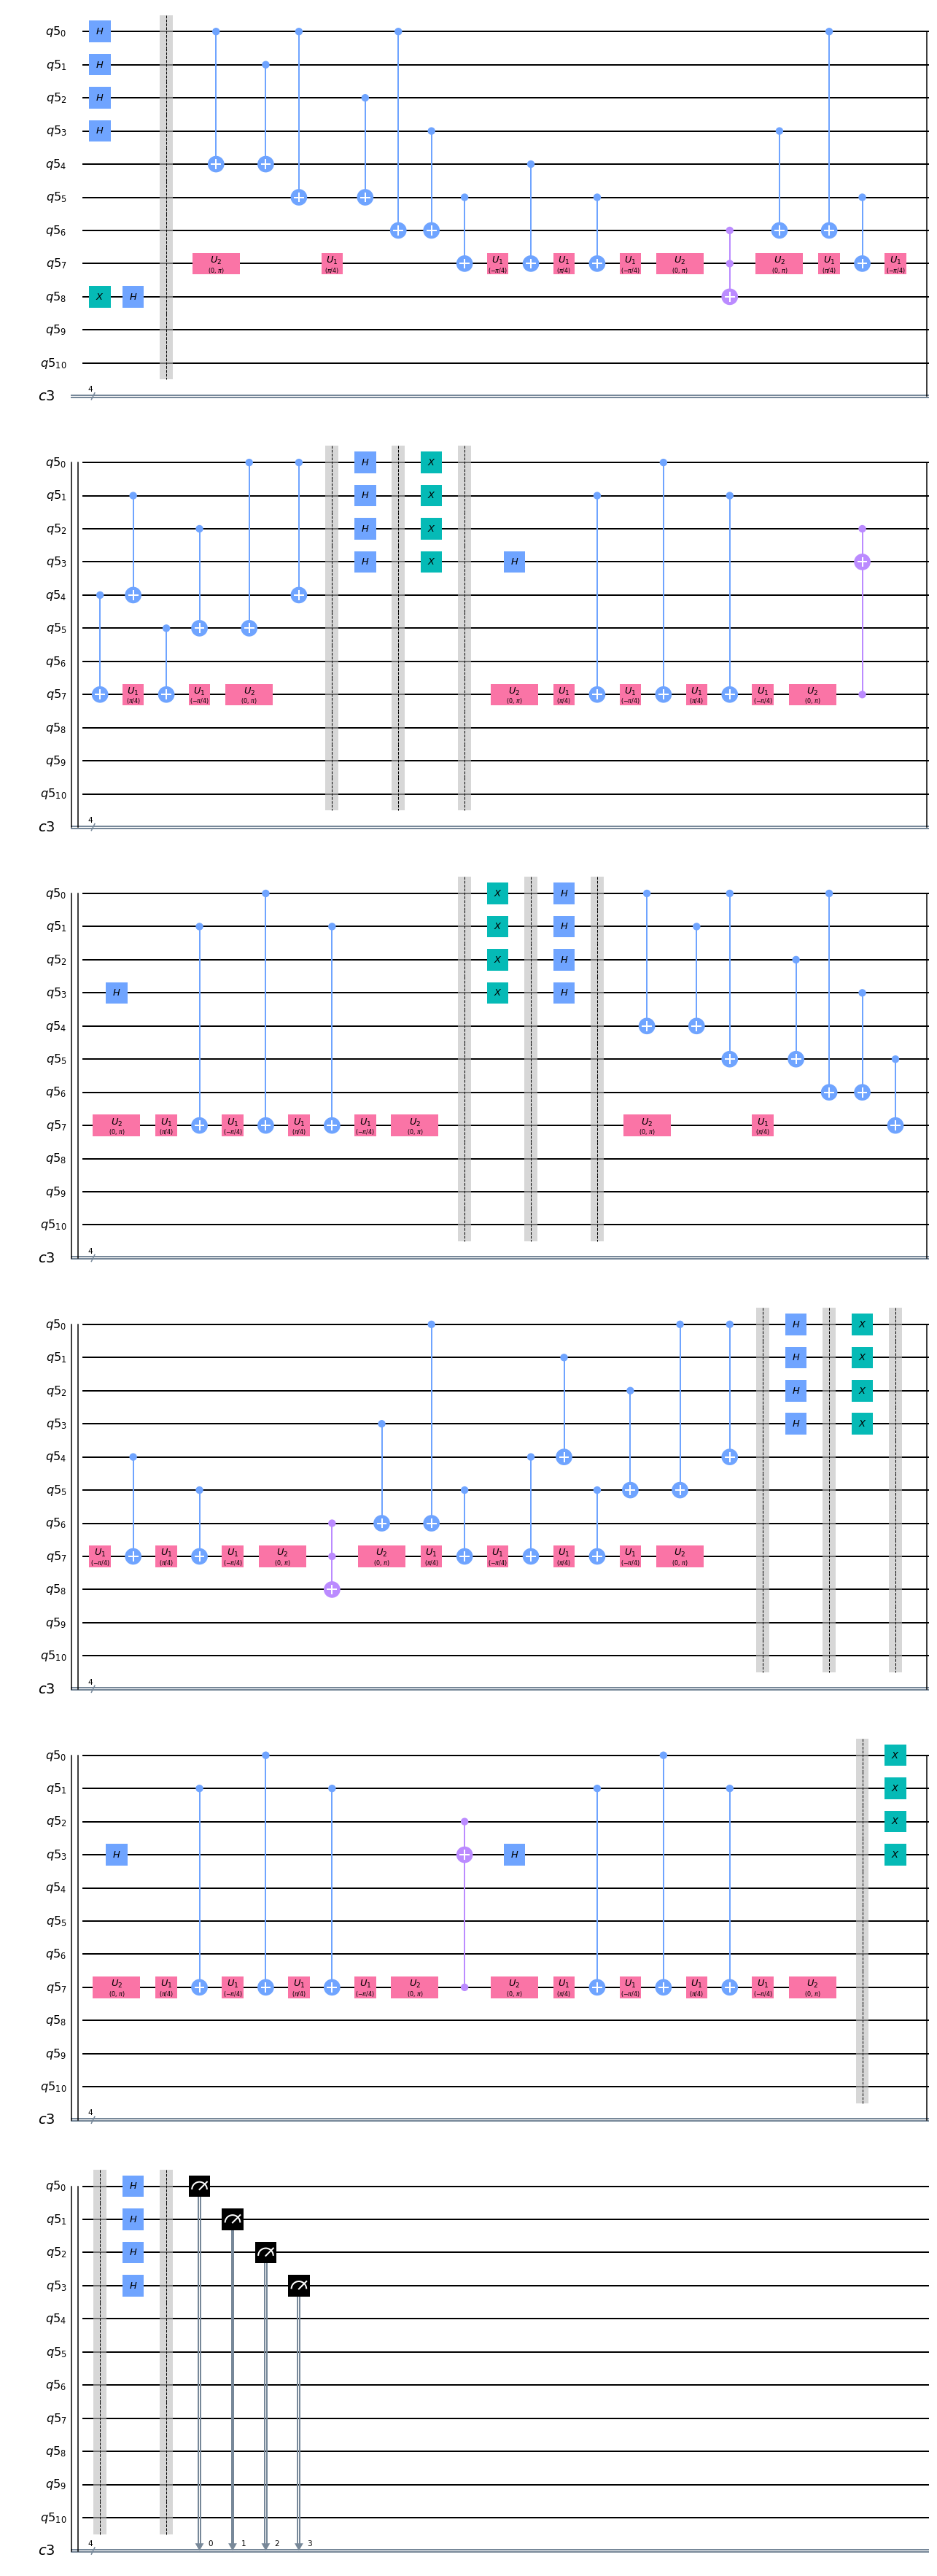

In [8]:
#from qiskit.aqua.circuits.gates import mct
q = QuantumRegister(11)
c = ClassicalRegister(4)
qc = QuantumCircuit(q,c)
ite = 2 #number of iteration

#initialization
qc.h(q[0:4])
qc.x(q[8])
qc.h(q[8])
qc.barrier()

for i in range(ite):
#oracle part
    ccheck(0,1,4)
    ccheck(0,2,5)
    ccheck(0,3,6) 
    qc.mct([q[4],q[5],q[6]], q[8] , [q[7]], mode='basic') 
    iccheck(0,3,6)
    iccheck(0,2,5)
    iccheck(0,1,4)
    qc.barrier()
#diffusion part
    qc.h(q[0:4])
    qc.barrier()
    qc.x(q[0:4])
    qc.barrier()
    qc.h(q[3])
    qc.mct([q[0],q[1],q[2]], q[3] , [q[7]], mode='basic')
    qc.h(q[3])
    qc.barrier()
    qc.x(q[0:4])
    qc.barrier()
    qc.h(q[0:4])
    qc.barrier()

qc.measure(q[0:4], c[0:4])

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=10000)
result = job.result()
count =result.get_counts()
print(count)
qc.draw(output='mpl')

# the measurement results for each quantum state will be shown in reverse order. (i.e. 1000 -> 0001, 0111-> 1110)

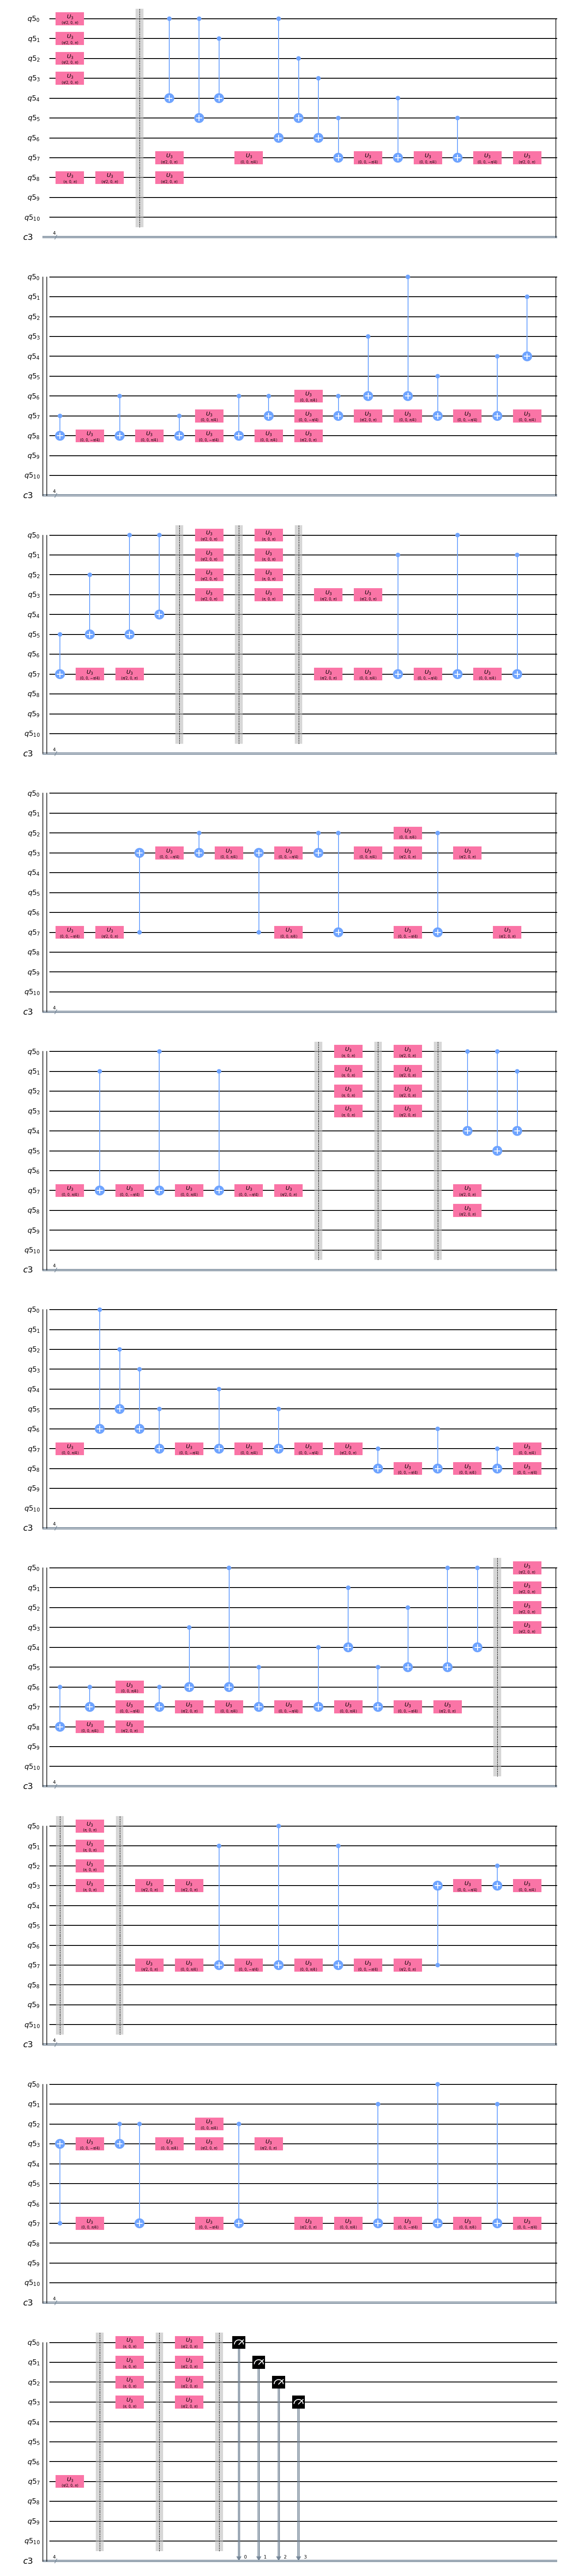

In [9]:
#Decompose the circuit by using the Unroller
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc) 
new_circuit.draw(output='mpl')

In [10]:
#show elementary gate counts
new_circuit.count_ops()

OrderedDict([('u3', 126), ('cx', 72), ('barrier', 13), ('measure', 4)])

In [11]:
#create output text file with the gate counts
import json
dct = new_circuit.count_ops()
with open('wk3_output.txt', 'w') as f:
    f.write(json.dumps(dct))